As we've selected the best model we can make submission on test data. Result visualization and model interpretation (e.g. feature importance) can also be explored here.

In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
import ivpk

RDKit WARNING: [18:04:42] Enabling RDKit 2019.09.3 jupyter extensions


## VDss

The best model we choose is `models/GridSearchCV/VDss_rfreg_gridsearch.pkl`

In [3]:
target = "VDss"
model_path = "models/GridSearchCV/VDss_rfreg_gridsearch.pkl"

#### Data

In [4]:
(x_train, x_train_smiles), y_train, (x_test, x_smiles), y_test = ivpk.data.all_datasets(
    target=target, 
    validation_size=None, 
)

#### Model

In [5]:
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [6]:
vdss_train = pd.DataFrame({    
    "SMILES": x_train_smiles, 
    "log2VDss": y_train, 
    "log2VDss_pred": model.predict(x_train), 
})
vdss_train.to_csv("results/VDss_train.csv")

#### Prediction

In [7]:
y_test_pred = model.predict(x_test)

In [8]:
print(f"""
MAE: {mean_absolute_error(y_test, y_test_pred)}, 
Pearsonr: {pearsonr(y_test, y_test_pred)}
""")


MAE: 1.3807894570595374, 
Pearsonr: (0.5748365540229746, 3.4667784605021914e-15)



#### Table for submission

In [9]:
vdss_pred = pd.DataFrame({    
    "SMILES": x_smiles, 
    "log2VDss": y_test, 
    "log2VDss_pred": y_test_pred, 
})

In [10]:
vdss_pred.head()

,SMILES,log2VDss,log2VDss_pred
0,[H]N([H])c1c2c(c3ccccc3n1)n(CCCCN([H])S(C)(=O)...,1.632268,0.964770
1,CN(C)Cc1c2ccccc2oc1C(=O)NCCOc3ccc(cc3)C(=O)NO,1.378512,0.117602
2,c1ccc(cc1)OCCC[N+]23CCC(CC2)[C@H](C3)OC(=O)C(c...,2.104337,0.201755
3,Cc1c2ccccc2oc1CN(C)C(=O)/C=C/c3cc4c(nc3)NC(=O)CC4,-1.217591,0.128100
4,CCc1cc2c(cc1N3CCC(CC3)N4CCOCC4)C(c5c(c6ccc(cc6...,2.666757,1.580203


In [11]:
vdss_pred.to_csv("submission/VDss.csv")

## CL

The best model we choose is `models/CL_mlp.pkl`.

In [12]:
target = "CL"
model_path = "models/CL_mlp.pkl"

#### Data

For MLP models, we need additional data transformation.

In [13]:
(x_train, x_train_smiles), y_train, (x_test, x_smiles), y_test = ivpk.data.all_datasets(
    target=target, 
    validation_size=None, 
)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

#### Model

In [14]:
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [15]:
cl_train = pd.DataFrame({    
    "SMILES": x_train_smiles, 
    "log2CL": y_train, 
    "log2CL_pred": model.predict(x_train).reshape(-1), 
})
cl_train.to_csv("results/CL_train.csv")

#### Prediction

In [16]:
y_test_pred = model.predict(x_test).reshape(-1)

In [17]:
print(f"""
MAE: {mean_absolute_error(y_test, y_test_pred)}, 
Pearsonr: {pearsonr(y_test, y_test_pred)}
""")


MAE: 1.4893762602600475, 
Pearsonr: (0.2893017110478897, 0.00018856564400894838)



#### Table for submission

In [18]:
cl_pred = pd.DataFrame({    
    "SMILES": x_smiles, 
    "log2CL": y_test, 
    "log2CL_pred": y_test_pred, 
})

In [19]:
cl_pred.to_csv("submission/CL.csv")

## Visualization

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
%load_ext autoreload
%autoreload 2
import ivpk

RDKit WARNING: [10:43:14] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
vdss = pd.read_csv("submission/VDss.csv", index_col=0)
cl = pd.read_csv("submission/CL.csv", index_col=0)

In [3]:
def plot_pred(df, x_col, y_col):
    "scatter plot of the predicted value"
    min_val = np.min(np.array(df[[x_col, y_col]]))
    max_val = np.max(np.array(df[[x_col, y_col]]))
    interval = max_val - min_val
    lims = (
        np.floor(min_val - 0.05*interval), 
        np.ceil(max_val + 0.05*interval)
    )
    plt.plot(df[x_col], df[y_col], ".")
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel(f"{x_col}")
    plt.ylabel(f"{y_col}")
    mae = mean_absolute_error(df[x_col], df[y_col])
    pear = pearsonr(df[x_col], df[y_col])[0]
    plt.title(f"MAE: {mae:.3f} Pearsonr: {pear:.3f}")

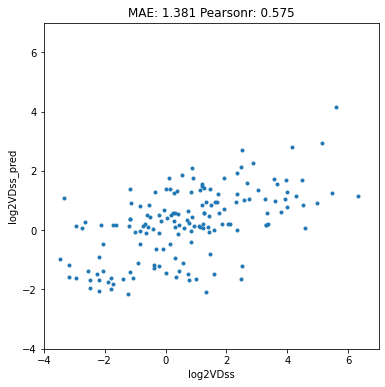

In [4]:
plt.figure(figsize=(6, 6))
plot_pred(vdss, "log2VDss", "log2VDss_pred")
plt.savefig("figures/VDss_testset.png")

Still a large space of improvement.

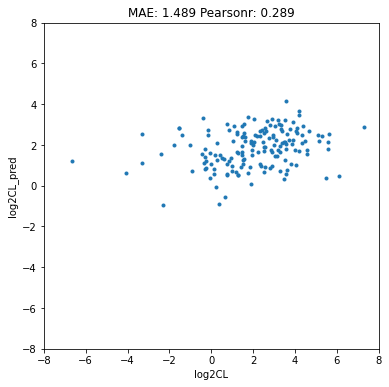

In [5]:
plt.figure(figsize=(6, 6))
plot_pred(cl, "log2CL", "log2CL_pred")
plt.savefig("figures/CL_testset.png")

Clearly the CL model is a high-bias one which didn't learnt much.

## Model analysis

This part we focus on VDss model.

In [3]:
with open("models/GridSearchCV/VDss_rfreg_gridsearch.pkl", "rb") as f:
    model = pickle.load(f)

#### Feature importance

In [9]:
model.best_estimator_

RandomForestRegressor(criterion='mae', max_features=0.2)

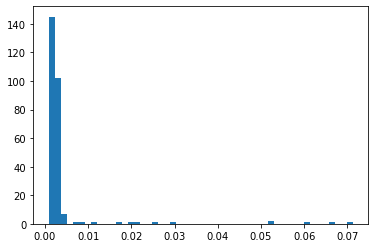

In [10]:
plt.hist(model.best_estimator_.feature_importances_, bins=50)
plt.show()

Only a small proportion of features have high importance. Let's see which are they.

In [4]:
important_ids = np.where(model.best_estimator_.feature_importances_>0.01)[0]
important_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 149])

In [12]:
model.best_estimator_.feature_importances_[important_ids]

array([0.05280533, 0.06635149, 0.02980465, 0.05283362, 0.02600196,
       0.02080696, 0.01759086, 0.07129605, 0.06012984, 0.01919435,
       0.01134635])

Clearly, the physiochemical properties are very important.

There is one bit in morgan256 whose importance is larger than 0.01. 

Note that the bit position 138 is 0-based. `fp.GetBit(0)` tells us if the first bit is on or off.

Let's plot the feature importance.

In [16]:
ivpk.data.x_preprocessor.transformers_

[('stdscl', StandardScaler(), ['MoKa.LogP', 'MoKa.LogD7.4', 'MW', 'TPSA_NO']),
 ('minmax', MinMaxScaler(), ['HBA', 'HBD', 'RotBondCount']),
 ('onehot',
  OneHotEncoder(categories=[['anionic', 'cationic', 'neutral', 'zwitterionic']],
                handle_unknown='ignore'),
  ['moka_ionState7.4']),
 ('remainder', 'drop', [0, 1, 2, 3, 4, 5, 6, 7])]

In [5]:
property_columns = (
    ivpk.data.x_preprocessor.transformers_[0][2] + 
    ivpk.data.x_preprocessor.transformers_[1][2] + 
    ivpk.data.x_preprocessor.transformers_[2][1].categories_[0].tolist()
)
# add the bit feature
property_positions = np.concatenate((np.arange(len(property_columns)), [important_ids[-1]]))
property_columns += ['bit138(morgan256)']
print(property_columns, "\n", property_positions)

['MoKa.LogP', 'MoKa.LogD7.4', 'MW', 'TPSA_NO', 'HBA', 'HBD', 'RotBondCount', 'anionic', 'cationic', 'neutral', 'zwitterionic', 'bit138(morgan256)'] 
 [  0   1   2   3   4   5   6   7   8   9  10 149]


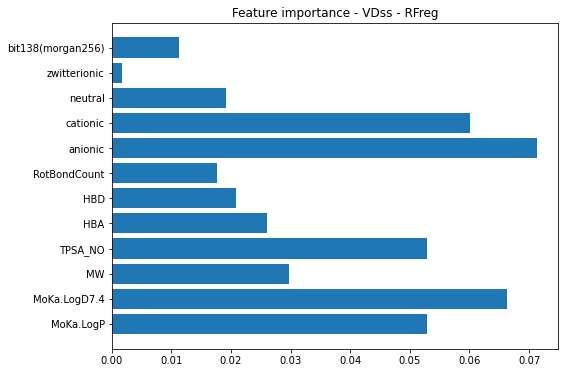

In [7]:
plt.figure(figsize=(8, 6))
plt.barh(
    np.arange(len(property_columns)), 
    width=model.best_estimator_.feature_importances_[property_positions]
)
plt.yticks(np.arange(len(property_columns)), property_columns)
plt.title("Feature importance - VDss - RFreg")
plt.savefig("figures/VDss_feature_importance.png", bbox_inches="tight")

The reason "zwitterionic" is not as important might be its small sample size.

#### Highlight bit 138

Now we can try highlight this bit 138 in compound image, following [RDkit fingerprint instruction](https://www.rdkit.org/docs/GettingStartedInPython.html#generating-images-of-fingerprint-bits) and [RDkit Draw instruction](https://www.rdkit.org/docs/GettingStartedInPython.html#drawing-molecules). The wrapped method is `ivpk.plots.draw_highlighted_bit`.

In [9]:
name, smiles = ivpk.data.pruned_df[["Name", "SMILES"]].sample().to_numpy()[0]
print(name, smiles)

Fosfluconazole OP(=O)(O)OC(Cn1cncn1)(Cn2cncn2)c3ccc(F)cc3F


In [10]:
bit = 138
nBits = 256
ivpk.plots.draw_highlighted_bit(
    fname=f"figures/highlight_FP/{name}_bit{bit}_morgan{nBits}.png", 
    mol=smiles, bit=bit, nBits=nBits
)

#### Hard samples

Let's examine which samples are hard to predict. Here we should first take a look at the train-val set.

In [42]:
raw_df = ivpk.data.raw_df.set_index("SMILES")
vdss_train = pd.read_csv("results/VDss_train.csv", index_col=0).set_index("SMILES")
cl_train = pd.read_csv("results/CL_train.csv", index_col=0).set_index("SMILES")

In [43]:
hard_train_vdss = vdss_train.loc[((vdss_train.log2VDss - vdss_train.log2VDss_pred).apply(abs) > 1), :]
hard_train_vdss.join(raw_df).to_csv("results/VDss_hard_train.csv")

In [44]:
hard_train_cl = cl_train.loc[((cl_train.log2CL - cl_train.log2CL_pred).apply(abs) > 1), :]
hard_train_cl.join(raw_df).to_csv("results/CL_hard_train.csv")

In [45]:
hard_vdss = vdss.loc[((vdss.log2VDss - vdss.log2VDss_pred).apply(abs) > 1), :]
hard_vdss.join(raw_df).to_csv("results/VDss_hard_test.csv")

In [46]:
hard_cl = cl.loc[((cl.log2CL - cl.log2CL_pred).apply(abs) > 1), :]
hard_cl.join(raw_df).to_csv("results/CL_hard_test.csv")

---